# Load Sentinel-2 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-2 data from the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en).

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../../README.md).

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
import itertools

import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema

from xcube_stac.utils import reproject_bbox

CPU times: user 3.84 s, sys: 327 ms, total: 4.16 s
Wall time: 2.45 s


In [2]:
xr.set_options(display_expand_attrs=False)

Next store the credentials in a dictionary. 

In [3]:
credentials = dict(
    key="O0M0CUQIDQO9TDZ4D8NR",
    secret="qPUyXs9G6j8on6MY5KPhQNHuA5uZTqxEscrbBCGx"
)

First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). Note that key and secret of the S3 access are required.

In [4]:
%%time
store_params = get_data_store_params_schema("stac-cdse-ardc")
store_params

CPU times: user 30.6 ms, sys: 9.82 ms, total: 40.4 ms
Wall time: 39.8 ms


Note that the user does not need to provide the URL for the [CDSE STAC API](https://documentation.dataspace.copernicus.eu/APIs/STAC.html). Only the key and secret for S3 access are required when initializing a `stac-cdse` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). First, we will initialize a store supporting the stacking mode. Then, for completeness, we will initialize a store in single-tile mode.

In [5]:
%%time
store = new_data_store("stac-cdse-ardc", **credentials)

CPU times: user 10.9 ms, sys: 1.89 ms, total: 12.8 ms
Wall time: 321 ms


The data IDs point to a STAC collections. So far only `'sentinel-2-l2a'` is supported.

In [6]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 17 μs, sys: 1e+03 ns, total: 18 μs
Wall time: 21 μs


['sentinel-2-l2a', 'sentinel-3-syn-2-syn-ntc']

Below, the parameters for the `open_data` method can be viewed.

In [7]:
%%time
open_params = store.get_open_data_params_schema("sentinel-2-l2a")
open_params

CPU times: user 39.4 ms, sys: 19.8 ms, total: 59.2 ms
Wall time: 58.6 ms


So far, only data from the collection `sentinel-2-l2a` can be accessed. We therefore assign `data_id` to `"sentinel-2-l2a"`. We set the bounding box to cover the greater Hamburg area and the time range to second half of July 2020.

In [8]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=[9.1, 53.1, 10.7, 54],
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10 / 111320, # meter in degree
    crs="EPSG:4326",
    asset_names=["B02", "B03", "B04", "SCL"],
    add_angles=True,
)
ds

CPU times: user 58.3 s, sys: 2.22 s, total: 1min
Wall time: 2min 40s


<xarray.Dataset> Size: 31GB
Dimensions:        (time: 11, lon: 17813, lat: 10020, angle_lon: 37,
                    angle_lat: 22, angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 88B 2020-07-15T10:15:59.024000 ... 2...
    spatial_ref    int64 8B 0
  * lon            (lon) float64 143kB 9.1 9.1 9.1 9.1 ... 10.7 10.7 10.7 10.7
  * lat            (lat) float64 80kB 54.0 54.0 54.0 54.0 ... 53.1 53.1 53.1
  * angle_lon      (angle_lon) float64 296B 9.1 9.146 9.191 ... 10.65 10.7 10.74
  * angle_lat      (angle_lat) float64 176B 54.04 54.0 53.95 ... 53.14 53.1
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, lat, lon) float32 8GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03            (time, lat, lon) float32 8GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04            (time, lat, lon) float32 8GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL            (time, lat, lon) float32 8GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    solar_angle    (angle, time, angle_lat, angle_lon) float32 72kB dask.array<chunksize=(2, 1, 22, 37), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_lat, angle_lon) float32 215kB dask.array<chunksize=(2, 3, 1, 22, 37), meta=np.ndarray>
Attributes: (3)

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.


CPU times: user 1min 32s, sys: 10 s, total: 1min 42s
Wall time: 2min 44s


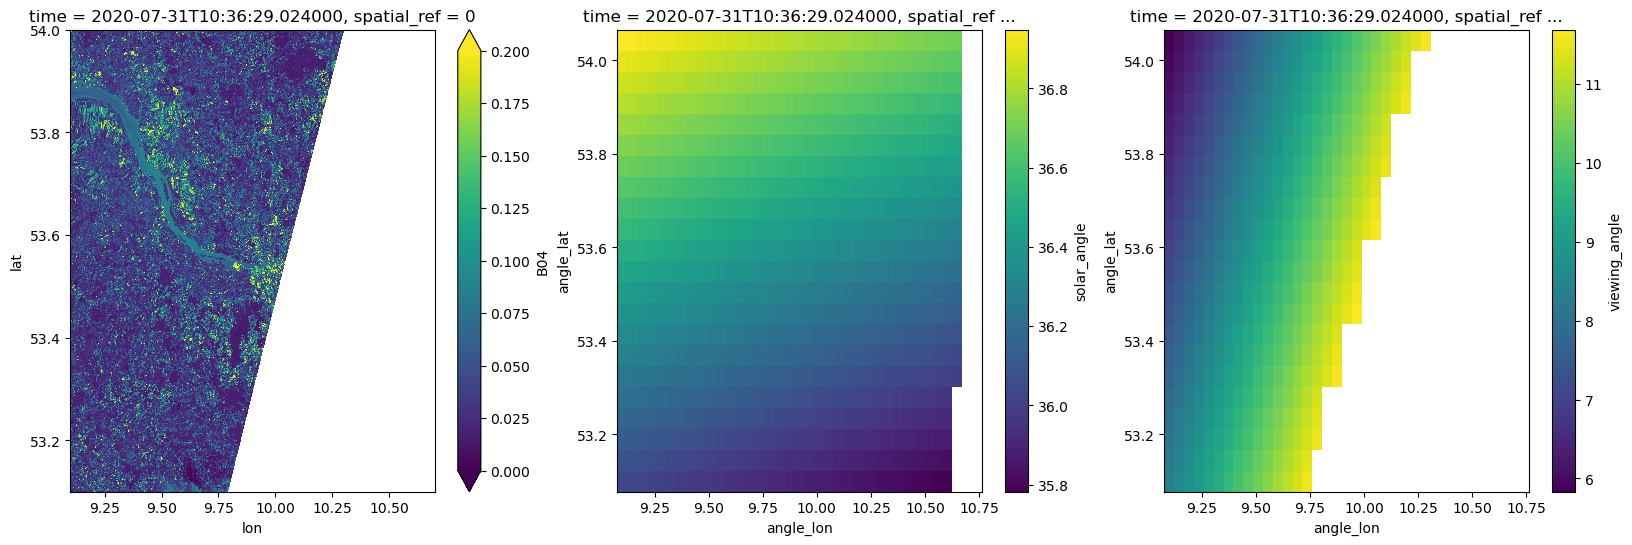

In [9]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

The data access can be speed up when requesting the data in the UTM CRS which is the native UTM of the Sentinel-2 products. 

In [10]:
%%time
bbox = [9.1, 53.1, 10.7, 54]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)

CPU times: user 1.18 ms, sys: 866 μs, total: 2.05 ms
Wall time: 1.14 ms


In [11]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2020-07-15", "2020-08-01"],
    spatial_res=10,
    crs=crs_target,
    asset_names=["B02", "B03", "B04", "SCL"],
    add_angles=True,
)
ds

CPU times: user 14.2 s, sys: 1.11 s, total: 15.3 s
Wall time: 2min 2s


<xarray.Dataset> Size: 19GB
Dimensions:        (time: 11, y: 10147, x: 10727, angle_x: 23, angle_y: 22,
                    angle: 2, band: 3)
Coordinates:
  * time           (time) datetime64[ns] 88B 2020-07-15T10:15:59.024000 ... 2...
    spatial_ref    int64 8B 0
  * x              (x) float64 86kB 5.066e+05 5.066e+05 ... 6.138e+05 6.138e+05
  * y              (y) float64 81kB 5.985e+06 5.985e+06 ... 5.883e+06 5.883e+06
  * angle_x        (angle_x) float64 184B 5.066e+05 5.116e+05 ... 6.166e+05
  * angle_y        (angle_y) float64 176B 5.988e+06 5.983e+06 ... 5.883e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, y, x) float32 5GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03            (time, y, x) float32 5GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04            (time, y, x) float32 5GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL            (time, y, x) float32 5GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    solar_angle    (angle, time, angle_y, angle_x) float32 45kB dask.array<chunksize=(2, 1, 22, 23), meta=np.ndarray>
    viewing_angle  (angle, band, time, angle_y, angle_x) float32 134kB dask.array<chunksize=(2, 3, 1, 22, 23), meta=np.ndarray>
Attributes: (3)

Note that the search function in the CDSE STAC API is very slow. Further investigation and comparison with other STAC APIs is needed. 

We can plot the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied. Additionally, we plot the solar and viewing angle.

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


CPU times: user 1min 7s, sys: 8.33 s, total: 1min 15s
Wall time: 1min 42s


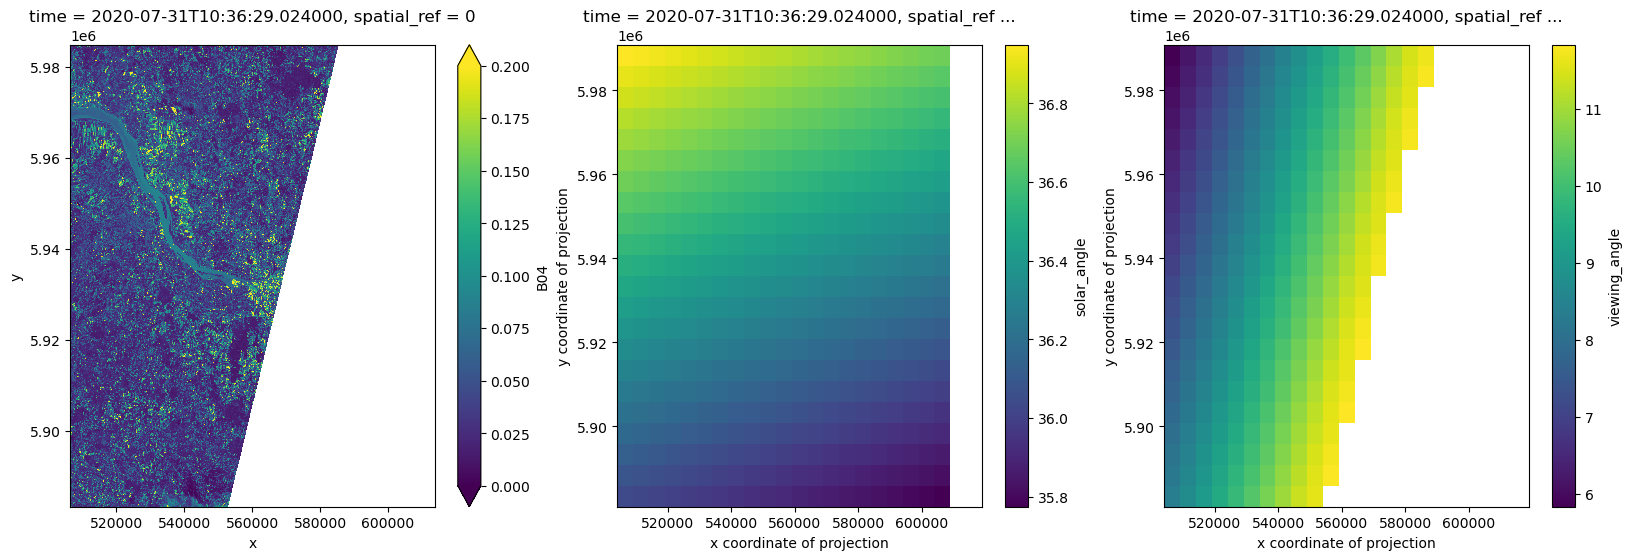

In [12]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=2, angle=0, time=-1).plot(ax=ax[2])

----
## Data store to access single observations
Now, we initiate the data store to access each STAC item representing one observation tile. 

In [13]:
%%time
store = new_data_store("stac-cdse", **credentials)

CPU times: user 6.27 ms, sys: 2.13 ms, total: 8.4 ms
Wall time: 275 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

⚠️ Warning: If you use `store.list_data_ids()` it will try to collect all Sentinel-2 tiles in the archive, before printing the result. This can take a while, and is not recommended. 

In [14]:
%%time
data_ids = store.get_data_ids()
list(itertools.islice(data_ids, 10))

NotImplementedError: Listing all data IDs is not supported in the 'stac-cdse' data store, because the underlying CDSE STAC API contains too many items. Use the `search_data()` method to find datasets matching your criteria.

In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [15]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 33 μs, sys: 0 ns, total: 33 μs
Wall time: 37 μs


 Next, we will search for tiles of Sentinel-2 data.

In [16]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l2a"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 199 ms, sys: 10.7 ms, total: 210 ms
Wall time: 4.9 s


[{'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UNU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999728, 47.755819, 10.493269, 48.753013],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UMU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.087776, 47.759622, 9.132783, 48.752937],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TNT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999733, 46.85664, 10.467277, 47.853702],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [7.760786, 46.858555, 9.13047, 47.853628],
  'time_range':

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [17]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 44 μs, sys: 4 μs, total: 48 μs
Wall time: 50.8 μs


We select the band B04 (red), B03 (green), B02 (blue), and the science classification layer (SLC), and lazily load the corresponding data.

In [27]:
%%time
ds = store.open_data(
    "collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912",
    asset_names=["B04", "B03", "B02", "SCL"],
    add_angles=True,
)
ds

CPU times: user 230 ms, sys: 21.1 ms, total: 251 ms
Wall time: 2.26 s


<xarray.Dataset> Size: 2GB
Dimensions:        (y: 10980, x: 10980, angle_x: 23, angle_y: 23, angle: 2,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle_x        (angle_x) float64 184B 4e+05 4.05e+05 ... 5.05e+05 5.1e+05
  * angle_y        (angle_y) float64 184B 5.3e+06 5.295e+06 ... 5.19e+06
  * angle          (angle) object 16B 'zenith' 'azimuth'
  * band           (band) <U3 36B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    SCL            (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    viewing_angle  (angle, band, angle_y, angle_x) float32 13kB dask.array<chunksize=(2, 3, 23, 23), meta=np.ndarray>
Attributes: (3)

We plot the loaded data as an example below.

CPU times: user 16.6 s, sys: 1.23 s, total: 17.8 s
Wall time: 24.3 s


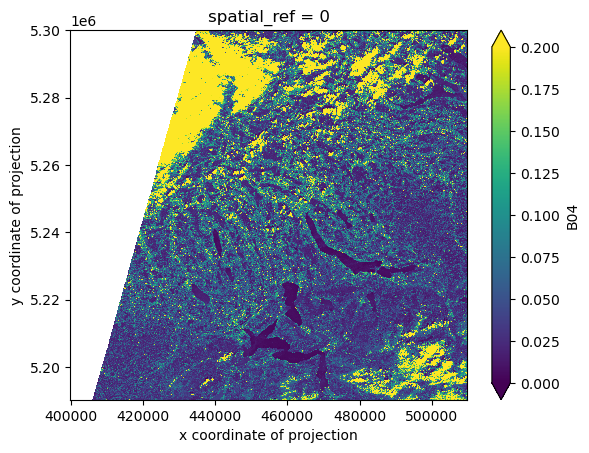

In [28]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)